In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from scipy.optimize import minimize
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False


# Exercise 1

In [2]:
sectors = np.array([1,2,1,1,2,2,2,1])

b_i = (np.array([9.5, 15.5, 5.5, 8.5, 10.0, 25.0, 17.0, 9.0]) / 100 ).reshape(-1,1)

mu_i = (np.array([5.00, 5.50, 6.00, 4.00, 7.00, 10.00, 8.75, 6.25]) / 100).reshape(-1,1)

sigma_i = (np.array([20.0, 22.0, 25.0, 18.0, 45.0, 80.0, 35.0, 40.5]) / 100).reshape(-1,1) 

S_i = (np.array([-2.0, +2.5, +1.5, +2.0, -1.0, -0.5, -0.5, +0.5])).reshape(-1,1)

CI_i = (np.array([80, 200, 390, 800, 60, 120, 135, 580])).reshape(-1,1)

CM_i = (np.array([-5.0, -7.5, -1.5, -2.0, +8.0, -4.0, -7.0, +2.0]) / 100).reshape(-1,1)

GI_i = (np.array([5.0, 80.5, 15.0, 0.0, 2.0, 0.0, 60.0, 20.0]) / 100 ).reshape(-1,1) 

correlation = np.array([
    [1.00, 0.50, 0.30, 0.60, 0.40, 0.30, 0.40, 0.30],
    [0.50, 1.00, 0.30, 0.60, 0.30, 0.20, 0.60, 0.30],
    [0.30, 0.30, 1.00, 0.60, 0.50, 0.40, 0.50, 0.50],
    [0.60, 0.60, 0.60, 1.00, 0.30, 0.70, 0.60, 0.30],
    [0.40, 0.30, 0.50, 0.30, 1.00, 0.50, 0.50, 0.30],
    [0.30, 0.20, 0.40, 0.70, 0.50, 1.00, 0.60, 0.30],
    [0.40, 0.60, 0.50, 0.60, 0.50, 0.60, 1.00, 0.60],
    [0.30, 0.30, 0.50, 0.30, 0.30, 0.30, 0.60, 1.00]
])

sigma_matrix = np.diag(sigma_i.flatten())

1a

In [3]:
covariance = sigma_matrix @ correlation @ sigma_matrix
covariance

array([[0.04    , 0.022   , 0.015   , 0.0216  , 0.036   , 0.048   ,
        0.028   , 0.0243  ],
       [0.022   , 0.0484  , 0.0165  , 0.02376 , 0.0297  , 0.0352  ,
        0.0462  , 0.02673 ],
       [0.015   , 0.0165  , 0.0625  , 0.027   , 0.05625 , 0.08    ,
        0.04375 , 0.050625],
       [0.0216  , 0.02376 , 0.027   , 0.0324  , 0.0243  , 0.1008  ,
        0.0378  , 0.02187 ],
       [0.036   , 0.0297  , 0.05625 , 0.0243  , 0.2025  , 0.18    ,
        0.07875 , 0.054675],
       [0.048   , 0.0352  , 0.08    , 0.1008  , 0.18    , 0.64    ,
        0.168   , 0.0972  ],
       [0.028   , 0.0462  , 0.04375 , 0.0378  , 0.07875 , 0.168   ,
        0.1225  , 0.08505 ],
       [0.0243  , 0.02673 , 0.050625, 0.02187 , 0.054675, 0.0972  ,
        0.08505 , 0.164025]])

1b

In [4]:
benchmark_volatility=np.sqrt(b_i.T@covariance@b_i)
benchmark_volatility

array([[0.32626319]])

1c

In [5]:
CI_benchmark = (b_i.T @ CI_i).squeeze()
print(f"CI_benchmark: {CI_benchmark:.5f}\n")

CM_benchmark = (b_i.T @ CM_i).squeeze()
print(f"CM_benchmark: {CM_benchmark:.5f}\n")

GI_benchmark = (b_i.T @ GI_i).squeeze()
print(f"GI_benchmark: {GI_benchmark:.5f}\n")

S_benchmark = (b_i.T @ S_i).squeeze()
print(f"S_benchmark: {S_benchmark:.5f}\n")


CI_benchmark: 239.20000

CM_benchmark: -0.03100

GI_benchmark: 0.25978

S_benchmark: 0.18500



1d

In [6]:
def sector_divisor (b_i):
    weighted_S1=b_i.copy()
    weighted_S1[1]=0
    weighted_S1[4]=0
    weighted_S1[5]=0
    weighted_S1[6]=0
    
    S1_allocation = np.sum(weighted_S1)
    
    weighted_S1=weighted_S1/(S1_allocation)
    

    weighted_S2=b_i.copy()
    weighted_S2[0]=0
    weighted_S2[2]=0
    weighted_S2[3]=0
    weighted_S2[7]=0
    
    S2_allocation = np.sum(weighted_S2)

    weighted_S2=weighted_S2/(S2_allocation)
    
    return weighted_S1,weighted_S2,S1_allocation,S2_allocation


weighted_S1,weighted_S2,_,_= sector_divisor(b_i)
    


# Exercise 2

2a

We consider the following **Quadratic Programming (QP)** problem:

$$
x^* = \arg\min \frac{1}{2} (x-b)^T Q (x-b)
$$



subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

The objective function can be rewritten equivalently as:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$



where:

$$
A = \begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 1 \end{bmatrix}
$$

$$
Q = \Sigma
$$

$$
R= \Sigma  b
$$


$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ CI^*(t)
\end{bmatrix}
$$



In [7]:
def Decarbonization_Solver(covariance, b, CI_star_t):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')

    C = matrix(np.vstack((np.eye(N), -np.eye(N), np.array([[80, 200, 390, 800, 60, 120, 135, 580]]))), tc='d')
    D = matrix(np.vstack((np.full((N, 1), 1), np.full((N, 1), 0), np.array([[CI_star_t]]))), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio


2b

<Figure size 1000x600 with 0 Axes>

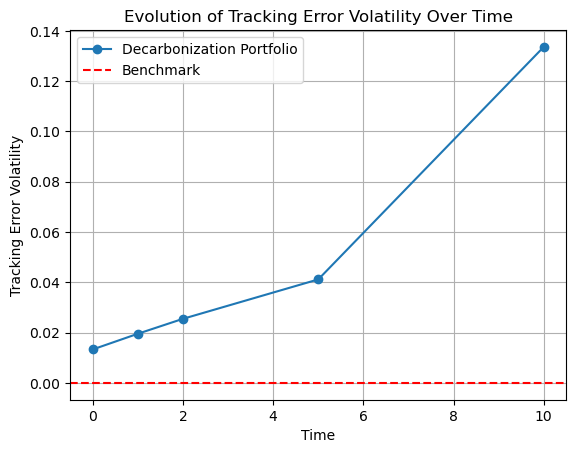

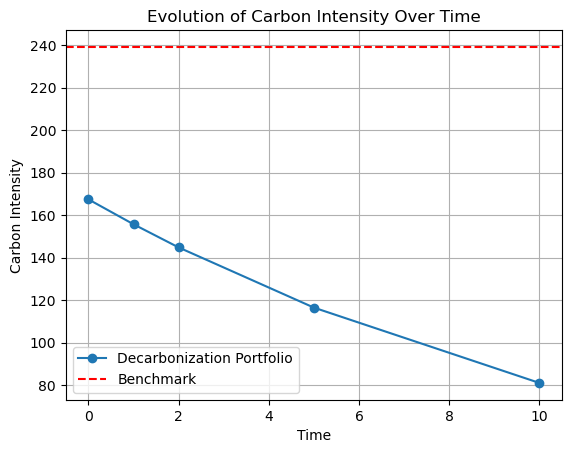

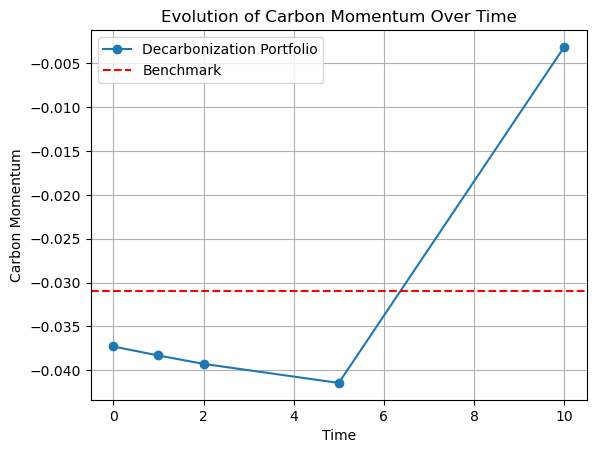

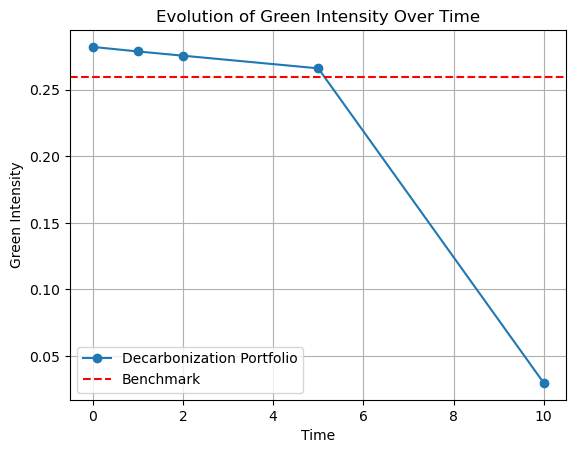

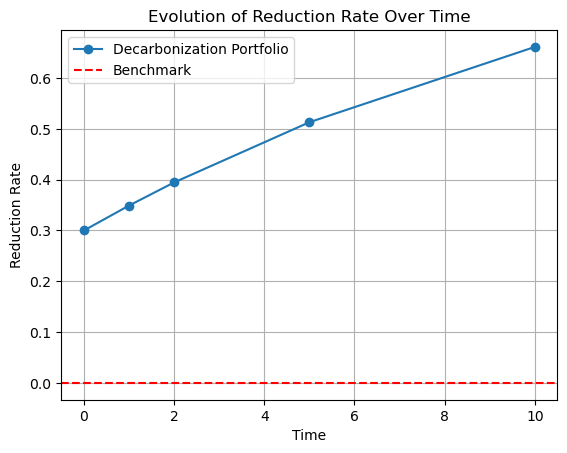

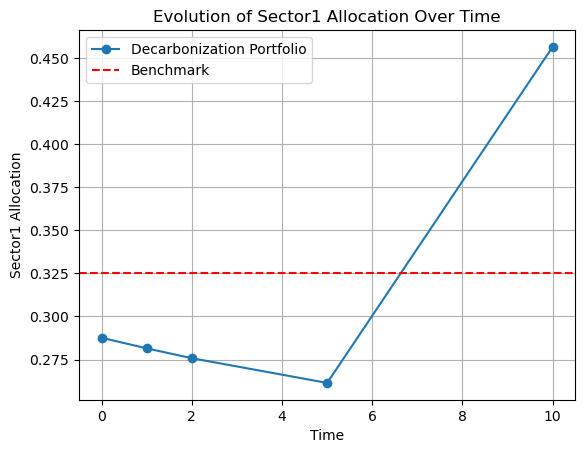

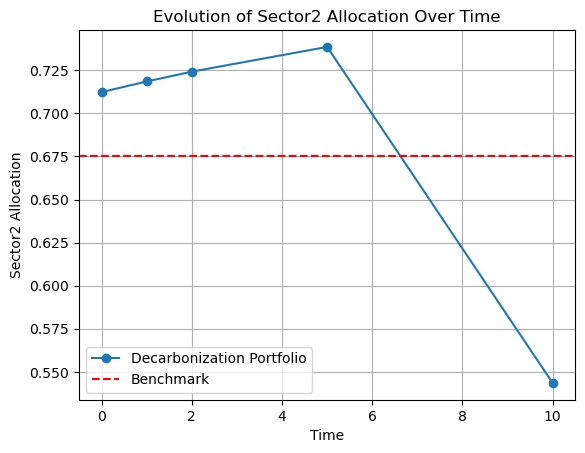

In [8]:
Times = [0, 1, 2, 5, 10]

portfolios = {}
metrics = {
    "Tracking Error Volatility": [],
    "Carbon Intensity": [],
    "Carbon Momentum": [],
    "Green Intensity": [],
    "Reduction Rate": [],
    "Sector1 Allocation": [],
    "Sector2 Allocation": []
}

for time in Times:
    portfolios[time] = Decarbonization_Solver(covariance, b_i, (1 - 0.3) * (1 - 0.07) ** time * CI_benchmark)
    
for time in portfolios:
    tracking_error_volatility = np.sqrt(((portfolios[time] - b_i).T @ covariance @ (portfolios[time] - b_i)).squeeze())
    carbon_intensity = (portfolios[time].T @ CI_i).squeeze()
    carbon_momentum = (portfolios[time].T @ CM_i).squeeze()
    green_intensity = (portfolios[time].T @ GI_i).squeeze()
    reduction_rate = (1 - ((portfolios[time].T @ CI_i) / CI_benchmark)).squeeze()

    sector1_allocation = sector_divisor(portfolios[time])[2] 
    sector2_allocation = sector_divisor(portfolios[time])[3] 

    metrics["Tracking Error Volatility"].append(tracking_error_volatility)
    metrics["Carbon Intensity"].append(carbon_intensity)
    metrics["Carbon Momentum"].append(carbon_momentum)
    metrics["Green Intensity"].append(green_intensity)
    metrics["Reduction Rate"].append(reduction_rate)
    metrics["Sector1 Allocation"].append(sector1_allocation)
    metrics["Sector2 Allocation"].append(sector2_allocation)

benchmark_metrics = {
    "Tracking Error Volatility": ((b_i - b_i).T @ covariance @ (b_i - b_i)).squeeze(),
    "Carbon Intensity": (b_i.T @ CI_i).squeeze(),
    "Carbon Momentum": (b_i.T @ CM_i).squeeze(),
    "Green Intensity": (b_i.T @ GI_i).squeeze(),
    "Reduction Rate": (1 - ((b_i.T @ CI_i) / CI_benchmark)).squeeze(),
    "Sector1 Allocation": sector_divisor(b_i)[2] ,
    "Sector2 Allocation": sector_divisor(b_i)[3]
}

plt.figure(figsize=(10, 6))
for metric in metrics.keys():
    plt.figure()
    plt.plot(Times, metrics[metric], marker='o', linestyle='-', label="Decarbonization Portfolio")
    plt.axhline(y=benchmark_metrics[metric], color='r', linestyle='--', label="Benchmark")
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.title(f"Evolution of {metric} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
print("\n" + "=" * 50)
print("Decarbonization Portfolio Evolution Over Time")
print("=" * 50)

for i, time in enumerate(Times):
    print(f"Portfolio time: {time}")
    print(portfolios[time])
    print("\n" + "=" * 50)

    print(f"Tracking error volatility: {metrics['Tracking Error Volatility'][i]:.8f}")
    print(f"Carbon Intensity: {metrics['Carbon Intensity'][i]:.8f}")
    print(f"Carbon Momentum: {metrics['Carbon Momentum'][i]:.8f}")
    print(f"Green Intensity: {metrics['Green Intensity'][i]:.8f}")
    print(f"Reduction Rate: {metrics['Reduction Rate'][i]:.8f}")
    print(f"Sector1 Allocation: {metrics['Sector1 Allocation'][i]:.8f}")
    print(f"Sector2 Allocation: {metrics['Sector2 Allocation'][i]:.8f}")

    print("\n" + "=" * 50)

print("\n" + "=" * 50)
print("Benchmark Values")
print("=" * 50)

print(f"Tracking error volatility: {benchmark_metrics['Tracking Error Volatility']:.8f}")
print(f"Carbon Intensity: {benchmark_metrics['Carbon Intensity']:.8f}")
print(f"Carbon Momentum: {benchmark_metrics['Carbon Momentum']:.8f}")
print(f"Green Intensity: {benchmark_metrics['Green Intensity']:.8f}")
print(f"Reduction Rate: {benchmark_metrics['Reduction Rate']:.8f}")
print(f"Sector1 Allocation: {benchmark_metrics['Sector1 Allocation']:.8f}")
print(f"Sector2 Allocation: {benchmark_metrics['Sector2 Allocation']:.8f}")

print("\n" + "=" * 50)



Decarbonization Portfolio Evolution Over Time
Portfolio time: 0
[[1.66212402e-01]
 [1.62811464e-01]
 [6.45383752e-02]
 [4.51918481e-06]
 [9.20664312e-02]
 [2.57677045e-01]
 [1.99817772e-01]
 [5.68719920e-02]]

Tracking error volatility: 0.01332761
Carbon Intensity: 167.43925238
Carbon Momentum: -0.03728122
Green Intensity: 0.28216099
Reduction Rate: 0.30000313
Sector1 Allocation: 0.28762729
Sector2 Allocation: 0.71237271

Portfolio time: 1
[[1.86816263e-01]
 [1.49645709e-01]
 [5.19104616e-02]
 [2.17194963e-06]
 [9.55818833e-02]
 [2.55456350e-01]
 [2.17826508e-01]
 [4.27606536e-02]]

Tracking error volatility: 0.01956190
Carbon Intensity: 155.71869306
Carbon Momentum: -0.03830729
Green Intensity: 0.27875185
Reduction Rate: 0.34900212
Sector1 Allocation: 0.28148955
Sector2 Allocation: 0.71851045

Portfolio time: 2
[[2.05976974e-01]
 [1.37409243e-01]
 [4.01536057e-02]
 [6.19056885e-08]
 [9.88538303e-02]
 [2.53391983e-01]
 [2.34570075e-01]
 [2.96442262e-02]]

Tracking error volatility: 0.

For 2c See the report

2d

We consider the following **Quadratic Programming (QP)** problem:

$$
x^* = \arg\min \frac{1}{2} (x-b)^T Q (x-b)
$$



subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

The objective function can be rewritten equivalently as:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$



where:

$$
A = \begin{bmatrix} 
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 0 & 1 & 1 & 0 & 0 & 0 & 1\\
\end{bmatrix}, \quad 
B = \begin{bmatrix} 1\\ 0.325  \end{bmatrix}
$$

$$
Q = \Sigma
$$

$$
R= \Sigma  b
$$


$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ CI^*(t)
\end{bmatrix}
$$



In [10]:
def Decarbonization_Solver_Neutrality(covariance, b, CI_star_t):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],  
        [1, 0, 1, 1, 0, 0, 0, 1] 
    ]), tc='d')
    
    B = matrix(np.array([1,0.325]).reshape(-1,1), tc='d')

    C = matrix(np.vstack((np.eye(N), -np.eye(N), np.array([[80, 200, 390, 800, 60, 120, 135, 580]]))), tc='d')
    D = matrix(np.vstack((np.full((N, 1), 1), np.full((N, 1), 0), np.array([[CI_star_t]]).reshape(-1,1))), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio


<Figure size 1000x600 with 0 Axes>

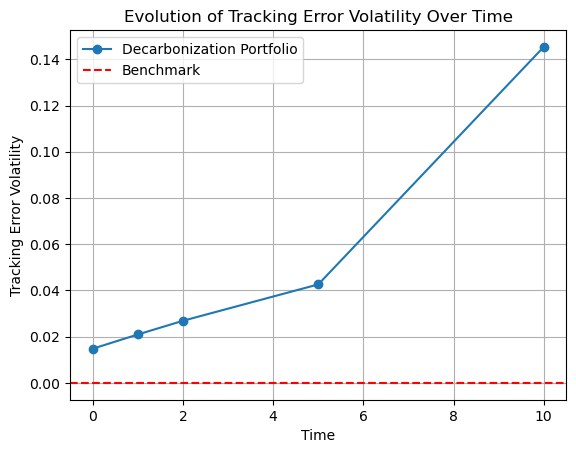

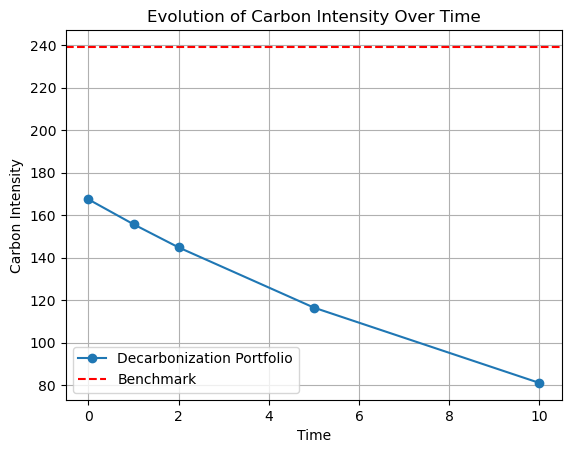

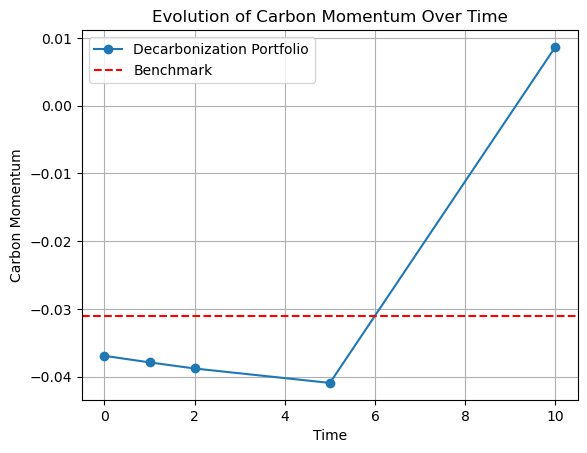

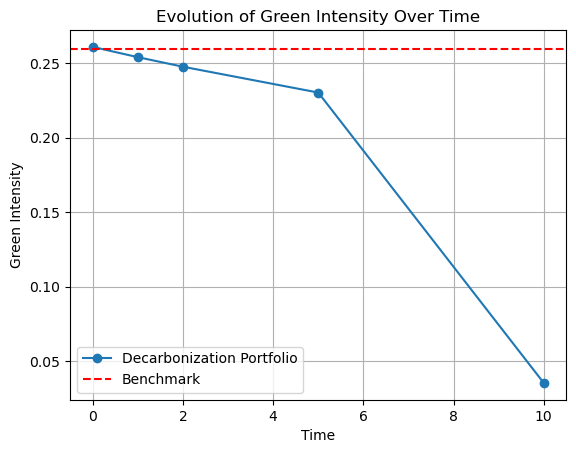

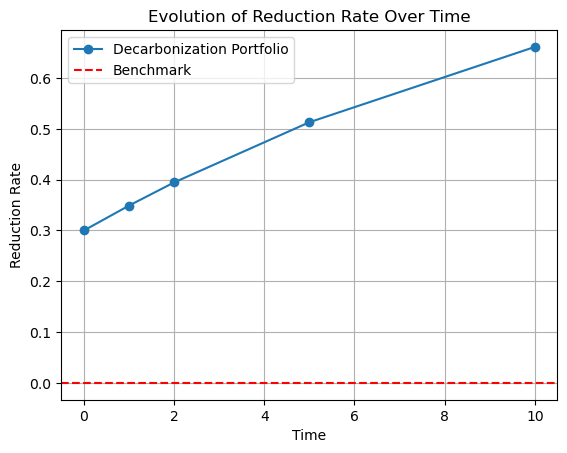

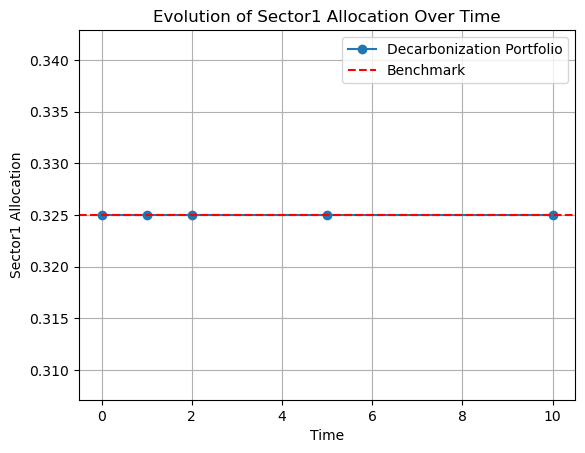

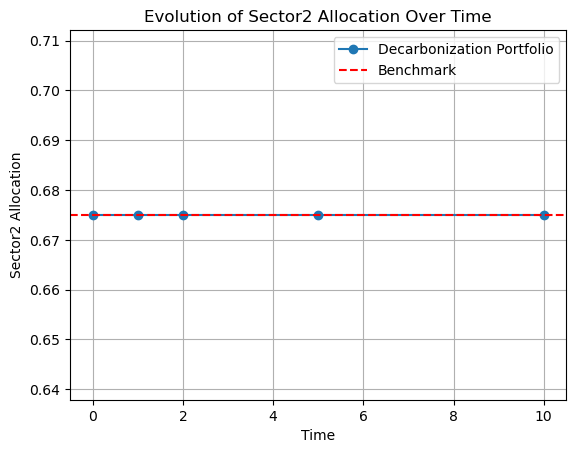

In [11]:
Times = [0, 1, 2, 5, 10]

portfolios = {}
metrics = {
    "Tracking Error Volatility": [],
    "Carbon Intensity": [],
    "Carbon Momentum": [],
    "Green Intensity": [],
    "Reduction Rate": [],
    "Sector1 Allocation": [],
    "Sector2 Allocation": []
}

for time in Times:
    portfolios[time] = Decarbonization_Solver_Neutrality(covariance, b_i, (1 - 0.3) * (1 - 0.07) ** time * CI_benchmark)

for time in portfolios:
    tracking_error_volatility = np.sqrt(((portfolios[time] - b_i).T @ covariance @ (portfolios[time] - b_i)).squeeze())
    carbon_intensity = (portfolios[time].T @ CI_i).squeeze()
    carbon_momentum = (portfolios[time].T @ CM_i).squeeze()
    green_intensity = (portfolios[time].T @ GI_i).squeeze()
    reduction_rate = (1 - ((portfolios[time].T @ CI_i) / CI_benchmark)).squeeze()

    sector1_allocation = sector_divisor(portfolios[time])[2] 
    sector2_allocation = sector_divisor(portfolios[time])[3] 

    metrics["Tracking Error Volatility"].append(tracking_error_volatility)
    metrics["Carbon Intensity"].append(carbon_intensity)
    metrics["Carbon Momentum"].append(carbon_momentum)
    metrics["Green Intensity"].append(green_intensity)
    metrics["Reduction Rate"].append(reduction_rate)
    metrics["Sector1 Allocation"].append(sector1_allocation)
    metrics["Sector2 Allocation"].append(sector2_allocation)

benchmark_metrics = {
    "Tracking Error Volatility": ((b_i - b_i).T @ covariance @ (b_i - b_i)).squeeze(),
    "Carbon Intensity": (b_i.T @ CI_i).squeeze(),
    "Carbon Momentum": (b_i.T @ CM_i).squeeze(),
    "Green Intensity": (b_i.T @ GI_i).squeeze(),
    "Reduction Rate": (1 - ((b_i.T @ CI_i) / CI_benchmark)).squeeze(),
    "Sector1 Allocation": sector_divisor(b_i)[2] ,
    "Sector2 Allocation": sector_divisor(b_i)[3]
}

plt.figure(figsize=(10, 6))
for metric in metrics.keys():
    plt.figure()
    plt.plot(Times, metrics[metric], marker='o', linestyle='-', label="Decarbonization Portfolio")
    plt.axhline(y=benchmark_metrics[metric], color='r', linestyle='--', label="Benchmark")
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.title(f"Evolution of {metric} Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
print("\n" + "=" * 50)
print("Decarbonization Portfolio Evolution Over Time")
print("=" * 50)

for i, time in enumerate(Times):
    print(f"Portfolio time: {time}")
    print(portfolios[time])
    print("\n" + "=" * 50)

    print(f"Tracking error volatility: {metrics['Tracking Error Volatility'][i]:.8f}")
    print(f"Carbon Intensity: {metrics['Carbon Intensity'][i]:.8f}")
    print(f"Carbon Momentum: {metrics['Carbon Momentum'][i]:.8f}")
    print(f"Green Intensity: {metrics['Green Intensity'][i]:.8f}")
    print(f"Reduction Rate: {metrics['Reduction Rate'][i]:.8f}")
    print(f"Sector1 Allocation: {metrics['Sector1 Allocation'][i]:.8f}")
    print(f"Sector2 Allocation: {metrics['Sector2 Allocation'][i]:.8f}")

    print("\n" + "=" * 50)

print("\n" + "=" * 50)
print("Benchmark Values")
print("=" * 50)

print(f"Tracking error volatility: {benchmark_metrics['Tracking Error Volatility']:.8f}")
print(f"Carbon Intensity: {benchmark_metrics['Carbon Intensity']:.8f}")
print(f"Carbon Momentum: {benchmark_metrics['Carbon Momentum']:.8f}")
print(f"Green Intensity: {benchmark_metrics['Green Intensity']:.8f}")
print(f"Reduction Rate: {benchmark_metrics['Reduction Rate']:.8f}")
print(f"Sector1 Allocation: {benchmark_metrics['Sector1 Allocation']:.8f}")
print(f"Sector2 Allocation: {benchmark_metrics['Sector2 Allocation']:.8f}")

print("\n" + "=" * 50)



Decarbonization Portfolio Evolution Over Time
Portfolio time: 0
[[1.92832507e-01]
 [1.33373660e-01]
 [7.44679766e-02]
 [3.35978178e-08]
 [8.58930531e-02]
 [2.56476801e-01]
 [1.99256485e-01]
 [5.76994828e-02]]

Tracking error volatility: 0.01481948
Carbon Intensity: 167.43999521
Carbon Momentum: -0.03694326
Green Intensity: 0.26098927
Reduction Rate: 0.30000002
Sector1 Allocation: 0.32500000
Sector2 Allocation: 0.67500000

Portfolio time: 1
[[2.17813004e-01]
 [1.15370322e-01]
 [6.34615269e-02]
 [2.13892593e-08]
 [8.83975136e-02]
 [2.54058295e-01]
 [2.17173869e-01]
 [4.37254474e-02]]

Tracking error volatility: 0.02096711
Carbon Intensity: 155.71919542
Carbon Momentum: -0.03791354
Green Intensity: 0.25410035
Reduction Rate: 0.34900002
Sector1 Allocation: 0.32500000
Sector2 Allocation: 0.67500000

Portfolio time: 2
[[2.41044879e-01]
 [9.86272040e-02]
 [5.32255247e-02]
 [3.04794860e-08]
 [9.07266805e-02]
 [2.51809079e-01]
 [2.33837037e-01]
 [3.07295662e-02]]

Tracking error volatility: 0.

## Exercise 3

In [13]:
#I will store here the next portfolios
constrained_portfolios = {} 

From 3a to 3e

First decarbonization constraint

We consider the following **Quadratic Programming (QP)** problem:

$$
x^* = \arg\min \frac{1}{2} (x-b)^T Q (x-b)
$$



subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

The objective function can be rewritten equivalently as:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$



where:

$$
A = \begin{bmatrix} 
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{bmatrix}, \quad 
B = \begin{bmatrix} 1\\  \end{bmatrix}
$$

$$
Q = \Sigma
$$

$$
R= \Sigma  b
$$


$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI(b)
\end{bmatrix}
$$



Now we add the Green Intensity Constraint



$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
-5\% & -80.5\% & -15\% & 0\% & -2\% & 0\% & -60\% & -20\%\\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI(b) \\ -150\%* GI(b)
\end{bmatrix}
$$

In [14]:
def Decarbonization_Solver_GI(covariance, b, CI_star_t,GI):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')

    C = matrix(np.vstack((-np.eye(N), np.array([[80, 200, 390, 800, 60, 120, 135, 580]]),
                         np.array([-0.05 , -0.805 , -0.15 , 0 , -0.02 , 0 , -0.6 ,-0.2]))), tc='d')
    
    D = matrix(np.vstack(( np.full((N, 1), 0), np.array([[CI_star_t]]) ,np.array([[-GI]]))), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio


Now we add the Carbon Momentum Constraint



$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
-5\% & -80.5\% & -15\% & 0\% & -2\% & 0\% & -60\% & -20\%\\
-5.0\% & -7.5\% & -1.5\% & -2.0\% & 8.0\% & -4.0\% & -7.0\% & 2.0\% \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI(b) \\ -150\%* GI(b) \\ 150\% CM(b)
\end{bmatrix}
$$

In [15]:
def Decarbonization_Solver_GI_CM(covariance, b, CI_star_t, GI, CM):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')

    C = matrix(np.vstack((
        -np.eye(N), 
        np.array([[80, 200, 390, 800, 60, 120, 135, 580]]),  
        np.array([[-0.05 , -0.805 , -0.15 , 0 , -0.02 , 0 , -0.6 , -0.2]]),  
        np.array([[-5.0, -7.5, -1.5, -2.0, +8.0, -4.0, -7.0, +2.0]]) / 100  
    )), tc='d')

    D = matrix(np.vstack((
        np.full((N, 1), 0),  
        np.array([[CI_star_t]]),  
        np.array([[-GI]]),  
        np.array([[CM]])  
    )), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio


Now we add the Carbon Momentum Constraint



$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 200 & 390 & 800 & 60 & 120 & 135 & 580 \\
-5\% & -80.5\% & -15\% & 0\% & -2\% & 0\% & -60\% & -20\%\\
-5.0\% & -7.5\% & -1.5\% & -2.0\% & 8.0\% & -4.0\% & -7.0\% & 2.0\% \\
2.0\% & -2.5\% & -1.5\% & -2.0\% & 1.0\% & 0.5\% & 0.5\% & -0.5\% 
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI(b) \\ -150\%* GI(b) \\ 150\% CM(b) \\ -S(b) -0.5
\end{bmatrix}
$$

In [16]:
def Decarbonization_Solver_GI_CM_S(covariance, b, CI_star_t, GI, CM, S):

    n = covariance.shape[0]
    x = cp.Variable(n)

    carbon_intensity = np.array([80, 200, 390, 800, 60, 120, 135, 580])
    
    green_intensity = np.array([0.05, 0.805, 0.15, 0, 0.02, 0, 0.6, 0.2])
    
    
    esg_score = np.array([-2, 2.5, 1.5, 2, -1, -0.5, -0.5, 0.5])

    
    carbon_momentum = np.array([-0.05, -0.075, -0.015, -0.02, 0.08, -0.04, -0.07, 0.02])
    
    benchmark_weights = np.array([0.095, 0.155, 0.055, 0.085, 0.1, 0.25, 0.17, 0.09])
    
    constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= CI_star_t, x @ green_intensity >= GI, x @ carbon_momentum <= CM, x @ esg_score >= S]
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, covariance))

    prob = cp.Problem(objective, constraints)
    prob.solve()
    x_opt = x.value
    if(x_opt is None):
        return None
    
    return x_opt.reshape(-1,1)

In [17]:
constrained_portfolios["CI"]=Decarbonization_Solver(covariance, b_i, 0.7*CI_benchmark)
constrained_portfolios["GI"]=Decarbonization_Solver_GI(covariance, b_i, 0.7*CI_benchmark,1.5*GI_benchmark)
constrained_portfolios["CM"]=Decarbonization_Solver_GI_CM(covariance, b_i, 0.7*CI_benchmark,1.5*GI_benchmark,1.5*CM_benchmark)
constrained_portfolios["S"]=Decarbonization_Solver_GI_CM_S(covariance, b_i, 0.7*CI_benchmark,1.5*GI_benchmark,1.5*CM_benchmark,S_benchmark+0.5)


In [18]:


portfolios_metrics = {
    "Tracking Error Volatility": {},
    "ESG Score": {},
    "Carbon Intensity": {},
    "Carbon Momentum": {},
    "Green Intensity": {},
    "Sector1 Allocation": {},
    "Sector2 Allocation": {}
}


for key in constrained_portfolios.keys():
    portfolio = constrained_portfolios[key]

    tracking_error_volatility = np.sqrt(((portfolio - b_i).T @ covariance @ (portfolio - b_i)).squeeze())
    esg_score = (portfolio.T @ S_i).squeeze()
    carbon_intensity = (portfolio.T @ CI_i).squeeze()
    carbon_momentum = (portfolio.T @ CM_i).squeeze()
    green_intensity = (portfolio.T @ GI_i).squeeze()
    sector1_allocation = np.sum(portfolio[sectors == 1])
    sector2_allocation = np.sum(portfolio[sectors == 2])

    portfolios_metrics["Tracking Error Volatility"][key] = tracking_error_volatility
    portfolios_metrics["ESG Score"][key] = esg_score
    portfolios_metrics["Carbon Intensity"][key] = carbon_intensity
    portfolios_metrics["Carbon Momentum"][key] = carbon_momentum
    portfolios_metrics["Green Intensity"][key] = green_intensity
    portfolios_metrics["Sector1 Allocation"][key] = sector1_allocation
    portfolios_metrics["Sector2 Allocation"][key] = sector2_allocation


    benchmark_metrics = {
    "Tracking Error Volatility": ((b_i - b_i).T @ covariance @ (b_i - b_i)).squeeze(),
    "ESG Score": (b_i.T @ S_i).squeeze(),
    "Carbon Intensity": (b_i.T @ CI_i).squeeze(),
    "Carbon Momentum": (b_i.T @ CM_i).squeeze(),
    "Green Intensity": (b_i.T @ GI_i).squeeze(),
    "Sector1 Allocation": np.sum(b_i[sectors == 1]),
    "Sector2 Allocation": np.sum(b_i[sectors == 2])
}


print("\n" + "=" * 50)
print("Optimized Portfolio Metrics")
print("=" * 50)

for key in constrained_portfolios.keys():
    print(f"\nPortfolio Type: {key}")
    print(constrained_portfolios[key])
    print("\n" + "=" * 50)
    print(f"Tracking error volatility: {portfolios_metrics['Tracking Error Volatility'][key]:.8f}")
    print(f"ESG Score: {portfolios_metrics['ESG Score'][key]:.8f}")
    print(f"Carbon Intensity: {portfolios_metrics['Carbon Intensity'][key]:.8f}")
    print(f"Carbon Momentum: {portfolios_metrics['Carbon Momentum'][key]:.8f}")
    print(f"Green Intensity: {portfolios_metrics['Green Intensity'][key]:.8f}")
    print(f"Sector1 Allocation: {portfolios_metrics['Sector1 Allocation'][key]:.8f}")
    print(f"Sector2 Allocation: {portfolios_metrics['Sector2 Allocation'][key]:.8f}")
    print("\n" + "=" * 50)

print("\n" + "=" * 50)
print("Benchmark Values")
print("=" * 50)





Optimized Portfolio Metrics

Portfolio Type: CI
[[1.66212402e-01]
 [1.62811464e-01]
 [6.45383752e-02]
 [4.51918481e-06]
 [9.20664312e-02]
 [2.57677045e-01]
 [1.99817772e-01]
 [5.68719920e-02]]

Tracking error volatility: 0.01332761
ESG Score: -0.12095739
Carbon Intensity: 167.43925238
Carbon Momentum: -0.03728122
Green Intensity: 0.28216099
Sector1 Allocation: 0.28762729
Sector2 Allocation: 0.71237271


Portfolio Type: GI
[[6.38477858e-02]
 [2.98198568e-01]
 [3.20063859e-02]
 [5.19456907e-07]
 [8.74671967e-02]
 [2.57159725e-01]
 [2.19018713e-01]
 [4.23011059e-02]]

Tracking error volatility: 0.03211119
ESG Score: 0.36140560
Carbon Intensity: 167.43980908
Carbon Momentum: -0.04381169
Green Intensity: 0.38966399
Sector1 Allocation: 0.13815580
Sector2 Allocation: 0.86184420


Portfolio Type: CM
[[7.63336427e-02]
 [2.90848520e-01]
 [4.18150668e-02]
 [2.24712041e-07]
 [6.73576347e-02]
 [2.59496766e-01]
 [2.28160971e-01]
 [3.59871749e-02]]

Tracking error volatility: 0.03289493
ESG Score: 0

3f

In [19]:
for R in np.arange(0, 1, 0.01):
    result=Decarbonization_Solver_GI_CM_S(covariance, b_i, (1-R)*CI_benchmark,1.5*GI_benchmark,1.5*CM_benchmark,S_benchmark+0.5)
    if result is None:
        R0 = R
        break

In [20]:
for R in np.arange(R0 - 0.1, R0 + 0.1, 0.0001):
    result=Decarbonization_Solver_GI_CM_S(covariance, b_i, (1-R)*CI_benchmark,1.5*GI_benchmark,1.5*CM_benchmark,S_benchmark+0.5)
    if result is None:
        print(f"There is no solution for R equal to: {R}")
        break

There is no solution for R equal to: 0.3927999999999898


## Exercise 4

4a

In [21]:
CI_Sector1 = np.sum(b_i[sectors==1] * CI_i[sectors==1])
CI_Sector2 = np.sum(b_i[sectors==2] * CI_i[sectors==2])
print("\n" + "=" * 50)
print("Carbon Intensity of Each Sector")
print("=" * 50)
print(f"Sector 1 Carbon Intensity: {CI_Sector1:.8f} = CI(1)")
print(f"Sector 2 Carbon Intensity: {CI_Sector2:.8f} = CI(2)")


Carbon Intensity of Each Sector
Sector 1 Carbon Intensity: 149.25000000 = CI(1)
Sector 2 Carbon Intensity: 89.95000000 = CI(2)


We come back to the first QP Problem formulation but now C and D change

$$
x^* = \arg\min \frac{1}{2} (x-b)^T Q (x-b)
$$



subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

The objective function can be rewritten equivalently as:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$



where:

$$
A = \begin{bmatrix} 
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{bmatrix}, \quad 
B = \begin{bmatrix} 1\\  \end{bmatrix}
$$

$$
Q = \Sigma
$$

$$
R= \Sigma  b
$$


$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 0 & 390 & 800 & 0 & 0 & 0 & 580 \\
0 & 200 & 0 & 0 & 60 & 120 & 135 & 0 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI_1(b) \\ 50\% CI_2(b)
\end{bmatrix}
$$



In [22]:
def Decarbonization_Solver_SectorCarbonIntensity(covariance, b, C1 , C2):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.ones((1, N)), tc='d')
    B = matrix(1.0, tc='d')

    C = matrix(np.vstack((np.eye(N), -np.eye(N), np.array([[80, 0, 390, 800, 0, 0, 0, 580]]), 
                         np.array([[0, 200, 0, 0, 60, 120, 135, 0]]) )), tc='d')
    D = matrix(np.vstack((np.full((N, 1), 1), np.full((N, 1), 0), np.array([[C1]]), np.array([[C2]]) )), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio

In [23]:
portfolio=Decarbonization_Solver_SectorCarbonIntensity(covariance,b_i,CI_Sector1*0.7,CI_Sector2*0.5)

Reintroducing the sector neutrality constraint

$$
x^* = \arg\min \frac{1}{2} (x-b)^T Q (x-b)
$$



subject to:

$$
Ax = B
$$
$$
Cx \leq D
$$

The objective function can be rewritten equivalently as:

$$
x^* = \arg\min \frac{1}{2} x^T Q x - x^T R
$$



where:

$$
A = \begin{bmatrix} 
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 0 & 1 & 1 & 0 & 0 & 0 & 1\\
\end{bmatrix}, \quad 
B = \begin{bmatrix} 1\\ 0.325  \end{bmatrix}
$$

$$
Q = \Sigma
$$

$$
R= \Sigma  b
$$


$$
C = \begin{bmatrix} 
-1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
80 & 0 & 390 & 800 & 0 & 0 & 0 & 580 \\
0 & 200 & 0 & 0 & 60 & 120 & 135 & 0 \\
\end{bmatrix}
$$

$$
D = \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 70\% CI_1(b) \\ 50\% CI_2(b)
\end{bmatrix}
$$



In [24]:
def Decarbonization_Solver_SectorCarbonIntensity_SectorNeutrality(covariance, b, C1 , C2):
    N = covariance.shape[0]    
    
    Q = matrix(covariance, tc='d')
    R = matrix(-covariance @ b, tc='d')  

    A = matrix(np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],  
        [1, 0, 1, 1, 0, 0, 0, 1] 
    ]), tc='d')
    
    B = matrix(np.array([1,0.325]).reshape(-1,1), tc='d')

    
    C = matrix(np.vstack((np.eye(N), -np.eye(N), np.array([[80, 0, 390, 800, 0, 0, 0, 580]]), 
                         np.array([[0, 200, 0, 0, 60, 120, 135, 0]]) )), tc='d')
    D = matrix(np.vstack((np.full((N, 1), 1), np.full((N, 1), 0), np.array([[C1]]), np.array([[C2]]) )), tc='d')

    sol = solvers.qp(Q, R, C, D, A, B)
    portfolio = np.array(sol['x'])  

    return portfolio


Optimized Portfolio Metrics (Sector Carbon Intensity Constrained)

Portfolio Type: Sector CI
[[4.37310981e-01]
 [1.81824613e-07]
 [8.21626787e-02]
 [6.78243604e-08]
 [9.74590737e-02]
 [2.58041066e-01]
 [6.04628416e-02]
 [6.45631094e-02]]

Tracking error volatility: 0.06886446
ESG Score: -0.97580683
Carbon Intensity: 149.44997321
Carbon Momentum: -0.02856406
Green Intensity: 0.08532961
Sector1 Allocation: 0.58403684
Sector2 Allocation: 0.41596316


Portfolio Type: Sector CI + Neutrality
[[1.89816096e-01]
 [2.82270449e-09]
 [1.04109134e-06]
 [4.94692469e-02]
 [6.00416679e-01]
 [7.45833076e-02]
 [1.03312055e-08]
 [8.57136160e-02]]

Tracking error volatility: 0.20315769
ESG Score: -0.87554366
Carbon Intensity: 149.44998813
Carbon Momentum: 0.03628407
Green Intensity: 0.03864203
Sector1 Allocation: 0.32500000
Sector2 Allocation: 0.67500000



<Figure size 1000x600 with 0 Axes>

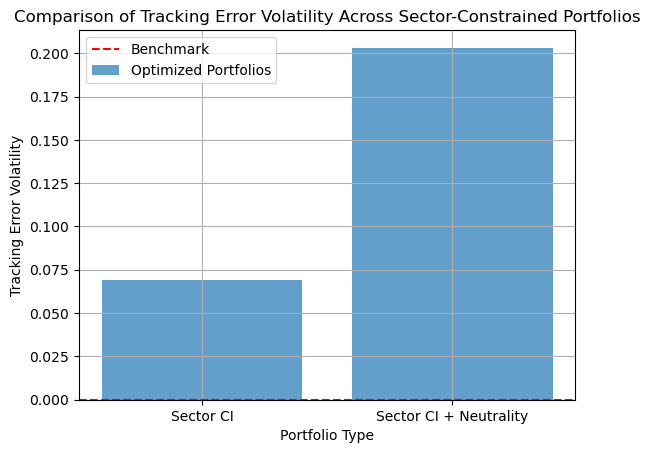

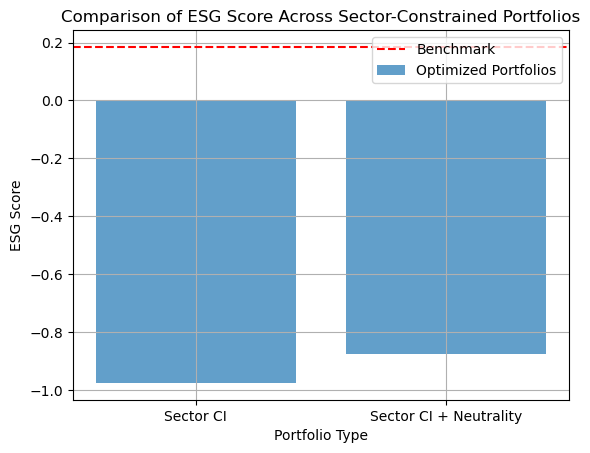

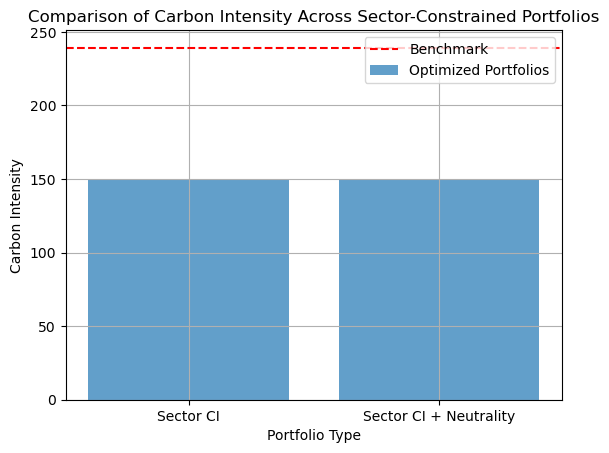

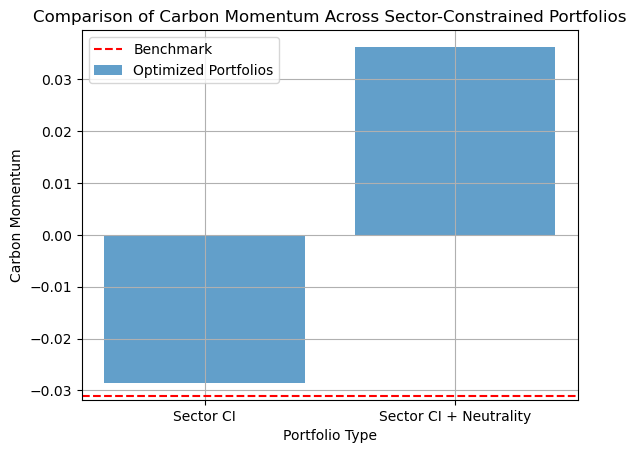

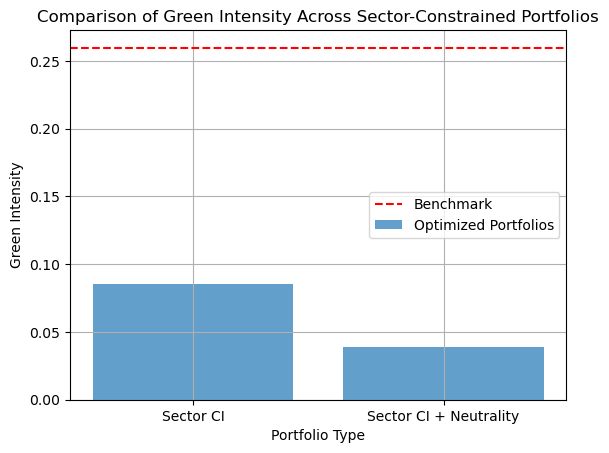

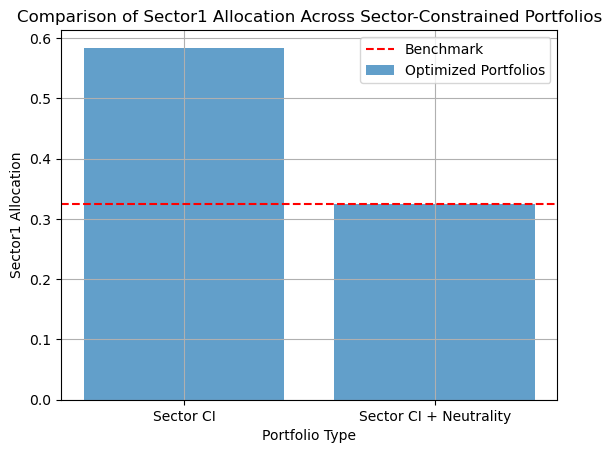

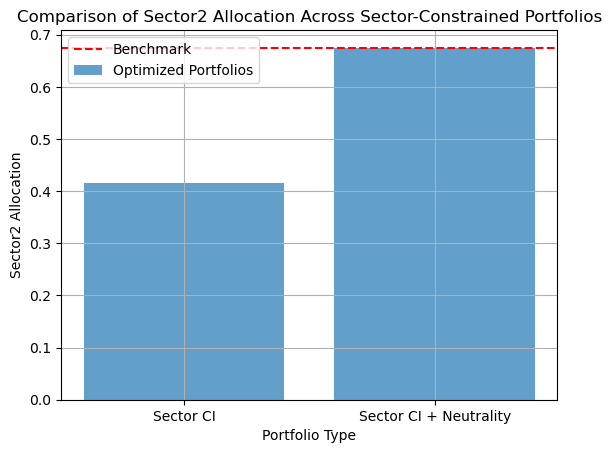

In [25]:
constrained_portfolios_sector = {
    "Sector CI": Decarbonization_Solver_SectorCarbonIntensity(covariance, b_i, CI_Sector1 * 0.7, CI_Sector2 * 0.5),
    "Sector CI + Neutrality": Decarbonization_Solver_SectorCarbonIntensity_SectorNeutrality(covariance, b_i, CI_Sector1 * 0.7, CI_Sector2 * 0.5)
}


portfolios_metrics_sector = {
    "Tracking Error Volatility": {},
    "ESG Score": {},
    "Carbon Intensity": {},
    "Carbon Momentum": {},
    "Green Intensity": {},
    "Sector1 Allocation": {},
    "Sector2 Allocation": {}
}

for key in constrained_portfolios_sector.keys():
    portfolio = constrained_portfolios_sector[key]

    tracking_error_volatility = np.sqrt(((portfolio - b_i).T @ covariance @ (portfolio - b_i)).squeeze())
    esg_score = (portfolio.T @ S_i).squeeze()
    carbon_intensity = (portfolio.T @ CI_i).squeeze()
    carbon_momentum = (portfolio.T @ CM_i).squeeze()
    green_intensity = (portfolio.T @ GI_i).squeeze()
    sector1_allocation = np.sum(portfolio[sectors == 1])
    sector2_allocation = np.sum(portfolio[sectors == 2])

    portfolios_metrics_sector["Tracking Error Volatility"][key] = tracking_error_volatility
    portfolios_metrics_sector["ESG Score"][key] = esg_score
    portfolios_metrics_sector["Carbon Intensity"][key] = carbon_intensity
    portfolios_metrics_sector["Carbon Momentum"][key] = carbon_momentum
    portfolios_metrics_sector["Green Intensity"][key] = green_intensity
    portfolios_metrics_sector["Sector1 Allocation"][key] = sector1_allocation
    portfolios_metrics_sector["Sector2 Allocation"][key] = sector2_allocation

print("\n" + "=" * 50)
print("Optimized Portfolio Metrics (Sector Carbon Intensity Constrained)")
print("=" * 50)

for key in constrained_portfolios_sector.keys():
    print(f"\nPortfolio Type: {key}")
    print(constrained_portfolios_sector[key])
    print("\n" + "=" * 50)
    print(f"Tracking error volatility: {portfolios_metrics_sector['Tracking Error Volatility'][key]:.8f}")
    print(f"ESG Score: {portfolios_metrics_sector['ESG Score'][key]:.8f}")
    print(f"Carbon Intensity: {portfolios_metrics_sector['Carbon Intensity'][key]:.8f}")
    print(f"Carbon Momentum: {portfolios_metrics_sector['Carbon Momentum'][key]:.8f}")
    print(f"Green Intensity: {portfolios_metrics_sector['Green Intensity'][key]:.8f}")
    print(f"Sector1 Allocation: {portfolios_metrics_sector['Sector1 Allocation'][key]:.8f}")
    print(f"Sector2 Allocation: {portfolios_metrics_sector['Sector2 Allocation'][key]:.8f}")
    print("\n" + "=" * 50)

plt.figure(figsize=(10, 6))
for metric in portfolios_metrics_sector.keys():
    plt.figure()
    plt.bar(portfolios_metrics_sector[metric].keys(), portfolios_metrics_sector[metric].values(), label="Optimized Portfolios", alpha=0.7)
    plt.axhline(y=benchmark_metrics[metric], color='r', linestyle='--', label="Benchmark")
    plt.xlabel("Portfolio Type")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} Across Sector-Constrained Portfolios")
    plt.legend()
    plt.grid(True)
    plt.show()
